In [17]:
from keras import backend as K
from keras.utils import np_utils
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape
from keras.layers.convolutional import Convolution3D, MaxPooling3D, AveragePooling3D
from keras.layers.convolutional import Convolution2D, MaxPooling2D, AveragePooling2D, UpSampling2D
from keras.layers import LSTM, TimeDistributed, CuDNNLSTM
from keras.layers import Input
from keras.models import Model
from keras.models import load_model
from keras.metrics import top_k_categorical_accuracy
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn import preprocessing
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline



In [3]:
def wrapped_confusion_matrix(modelInput, feature, label, class_list=["first", "second"], normalize=False, fig_size=(5,5)):
    pred = modelInput.predict(feature)
    cnf_matrix = confusion_matrix(np.argmax(label, axis=1), np.argmax(pred, axis=1))
    np.set_printoptions(precision=2)
    plt.figure(figsize=fig_size) 
    plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.xticks(np.arange(len(class_list)), class_list, rotation=45)
    plt.yticks(np.arange(len(class_list)), class_list)
    if(normalize):
        cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
    thresh = cnf_matrix.max() / 2.
    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, cnf_matrix[i, j],
                 horizontalalignment='center',
                 color='white' if cnf_matrix[i, j] > thresh else 'black')
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
def plot_history(model_input, mode='loss', val_mode=True, title='Entropy'):
    history = model_input.history
    if(val_mode):
        plt.plot(history.history[mode])
        plt.plot(history.history['val_'+mode])
        plt.title(title)
        plt.legend(['train', 'test'], loc='upper right')
        plt.show()
    else:
        plt.plot(history.history[mode])
        plt.title(title)
        plt.legend(['train'], loc='upper right')
        plt.show()

In [77]:
#Y_train, X_train = np_utils.to_categorical(np.load('../dataset/test/Y_train.npy')), np.load('../dataset/test/X_train.npy')
Y_train, X_train = np.load('../dataset/test/Y_train.npy'), np.load('../dataset/test/X_train.npy')
#Y_test, X_test = np_utils.to_categorical(np.load('../dataset/test/Y_test.npy')), np.load('../dataset/test/X_test.npy')
Y_test, X_test = np.load('../dataset/test/Y_test.npy'), np.load('../dataset/test/X_test.npy')
print(Y_train.shape, X_train.shape)
print(Y_test.shape, X_test.shape)

(3000, 3) (3000, 64, 64, 3)
(1000, 3) (1000, 64, 64, 3)


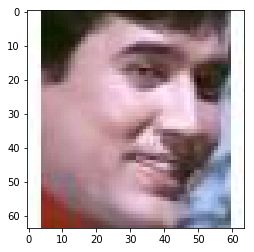

Index:  357 
 [1. 0. 0.]


In [78]:
instance_idx = np.random.randint(0, X_train.shape[0], 1)[0]
plt.imshow(X_train[instance_idx])
plt.show()
print('Index: ', instance_idx, '\n', Y_train[instance_idx])

In [79]:
# Feature Normalization
X_train, X_test = X_train/255., X_test/255.

In [103]:
# Model design

# Encoder
model_input = Input(X_train.shape[1:])
H = Reshape((X_train.shape[1], X_train.shape[2], X_train.shape[3]))(model_input)
H = Convolution2D(filters=16, kernel_size=(2, 2), padding='same', activation='tanh')(H)
H = MaxPooling2D((2, 2))(H)
H = Convolution2D(filters=16, kernel_size=(2, 2), padding='same', activation='tanh')(H)
H = MaxPooling2D((2, 2))(H)
# H = Convolution2D(filters=1, kernel_size=(2, 2), padding='same', activation='relu')(H)
# H = MaxPooling2D((2, 2))(H)
#H = Dropout(0.5)(H)

H = Flatten()(H)
H = Dense(256, activation='tanh')(H)
#H = Dense(Y_train.shape[1]*Y_train.shape[2], activation='softmax')(H)
#model_output = Reshape((Y_train.shape[1], Y_train.shape[2]))(H)
model_output = Dense(Y_train.shape[1], activation='softmax')(H)


# Decoder
# H = UpSampling2D(size=(2,2))(H)
# H = Convolution2D(filters=1, kernel_size=(2, 2), padding='same', activation='relu')(H)
# H = UpSampling2D(size=(2,2))(H)
# H = Convolution2D(filters=1, kernel_size=(2, 2), padding='same', activation='relu')(H)
#model_output = Reshape((X_train.shape[1], X_train.shape[2]))(H)


model_cae = Model(model_input, model_output)
model_cae.summary()
model_cae.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#model_cae.compile(loss='mse', optimizer='adam', metrics=['kullback_leibler_divergence', 'accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        (None, 64, 64, 3)         0         
_________________________________________________________________
reshape_38 (Reshape)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 64, 64, 16)        208       
_________________________________________________________________
max_pooling2d_63 (MaxPooling (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 32, 32, 16)        1040      
_________________________________________________________________
max_pooling2d_64 (MaxPooling (None, 16, 16, 16)        0         
_________________________________________________________________
flatten_23 (Flatten)         (None, 4096)              0         
__________

Train on 3000 samples, validate on 1000 samples
Epoch 1/20
 - 18s - loss: 0.9736 - acc: 0.4910 - val_loss: 0.9517 - val_acc: 0.5170
Epoch 2/20
 - 16s - loss: 0.9661 - acc: 0.4817 - val_loss: 0.9516 - val_acc: 0.5170
Epoch 3/20
 - 17s - loss: 0.9597 - acc: 0.5010 - val_loss: 0.9732 - val_acc: 0.4920
Epoch 4/20
 - 17s - loss: 0.9542 - acc: 0.5183 - val_loss: 0.9274 - val_acc: 0.5740
Epoch 5/20
 - 17s - loss: 0.9224 - acc: 0.5520 - val_loss: 0.8949 - val_acc: 0.5850
Epoch 6/20
 - 18s - loss: 0.8909 - acc: 0.5730 - val_loss: 0.8748 - val_acc: 0.5980
Epoch 7/20
 - 17s - loss: 0.8673 - acc: 0.5957 - val_loss: 0.9247 - val_acc: 0.5500
Epoch 8/20
 - 17s - loss: 0.8572 - acc: 0.6107 - val_loss: 0.8437 - val_acc: 0.6020
Epoch 9/20
 - 17s - loss: 0.8303 - acc: 0.6227 - val_loss: 0.8439 - val_acc: 0.6070
Epoch 10/20
 - 16s - loss: 0.8216 - acc: 0.6203 - val_loss: 0.8547 - val_acc: 0.5990
Epoch 11/20
 - 17s - loss: 0.8138 - acc: 0.6310 - val_loss: 0.8686 - val_acc: 0.5740
Epoch 12/20
 - 17s - loss:

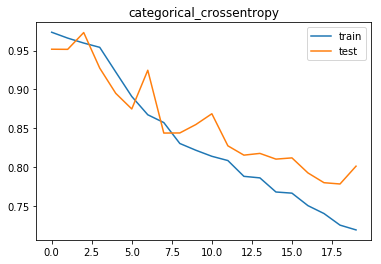

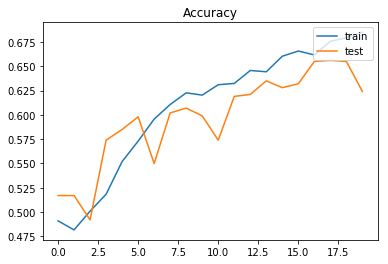

In [104]:
# Training
es = EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
#history_model_cae = model_cae.fit(X_train, X_train, validation_split=0.1, epochs=10, batch_size=64, verbose=2, shuffle=True, callbacks=[es])
history_model_cae = model_cae.fit(X_train, 
                                  Y_train,                                   
                                  validation_data=(X_test, Y_test),
                                  #validation_split=0.1, 
                                  epochs=20, 
                                  batch_size=64, 
                                  verbose=2, 
                                  shuffle=True, 
                                  callbacks=[es])

# Evaluate
#plot_history(model_cae, mode='loss', title='MSE')
plot_history(model_cae, mode='loss', title='categorical_crossentropy')
plot_history(model_cae, mode='acc', title='Accuracy')
model_cae.save('./test.model')

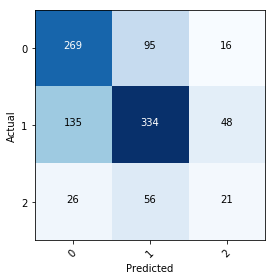

In [105]:
# Confusion Matrix
# Validation: Confusion Matrix Analysis
def plot_confusion_matrix(model_input, feature, label, class_info):
    pred = model_input.predict(feature)
    cnf_matrix = confusion_matrix(np.argmax(label, axis=1), np.argmax(pred, axis=1))
    plt.figure()
    plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    tick_marks = np.arange(len(class_info))
    plt.xticks(tick_marks, class_info, rotation=45), plt.yticks(tick_marks, class_info)
    thresh = cnf_matrix.max()/2.
    for i in range(cnf_matrix.shape[0]):
        for j in range(cnf_matrix.shape[1]):
            plt.text(j, i, cnf_matrix[i, j], horizontalalignment='center', color='white' if cnf_matrix[i,j]>thresh else 'black')
    plt.ylabel('Actual'), plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()
plot_confusion_matrix(model_cae, X_test, Y_test, range(0, 3))